In [1]:
# %matplotlib inline
# %config InlineBackend.close_figures=False 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!head -5 drone_delivery_v1.csv
!tail -5 drone_delivery_v1.csv

clientid;x;y
1;622.7715723;164.8576227
2;416.3572979;630.1936343
3;292.7350197;567.3332306
4;737.2112881;166.2256759
5952;832.8573939;616.8614096
5953;242.7345004;490.3250925
5954;108.6908474;758.8339212
5955;803.2510739;430.7406227
5956;481.3438988;285.9100546


In [3]:
drone_delivery_df = pd.read_csv(
    'drone_delivery_v1.csv',
    sep=';',
    index_col=0,
)
drone_delivery_df.head()

,x,y
clientid,,
1,622.771572,164.857623
2,416.357298,630.193634
3,292.735020,567.333231
4,737.211288,166.225676
5,540.475375,682.912298


Visualizing the data

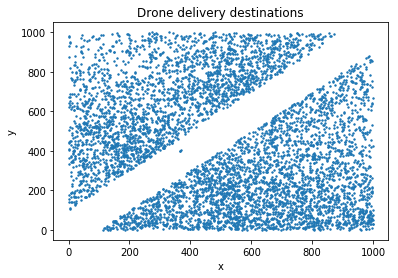

In [4]:
drone_delivery_df.plot.scatter('x', 'y', s=2).set_title(
    'Drone delivery destinations');

Looks like a forest after an emergency landing... :)

In [5]:
from sklearn import cluster
from ipywidgets import interact, fixed, widgets, interactive

In [6]:
import matplotlib.pyplot as plt

Attaching closest depot label to the destinations (for 3 clusters by k-means)

In [7]:
clustered_3means = cluster.KMeans(3).fit(drone_delivery_df)
drone_delivery_df_cluster_info = drone_delivery_df.copy()
drone_delivery_df_cluster_info['cluster'] = clustered_3means.labels_
drone_delivery_df_cluster_info.head(10)

,x,y,cluster
clientid,,,
1,622.771572,164.857623,0
2,416.357298,630.193634,1
3,292.735020,567.333231,2
4,737.211288,166.225676,0
5,540.475375,682.912298,1
6,535.469492,318.439661,0
7,640.380050,870.833221,1
8,235.772075,359.048203,2
9,481.896884,661.491838,1


In [8]:
def plot_clusters(df, clusters, title=None):
    plt.scatter(df.x, df.y, s=2, c=clusters.labels_, cmap='tab20')
    if hasattr(clusters, "cluster_centers_"):
        plt.scatter(
            clusters.cluster_centers_[:,0],
            clusters.cluster_centers_[:,1],
            s=80, c='red', alpha=0.5
        )
        if title: plt.title(title)

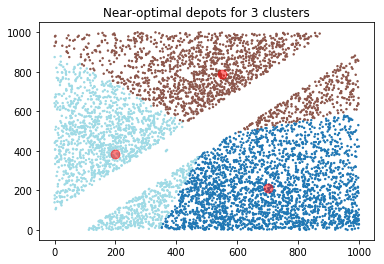

In [9]:
plot_clusters(drone_delivery_df, clustered_3means, 'Near-optimal depots for 3 clusters')

Playing a bit more with the number of depots

In [10]:
def compute_and_show_kmeans(n_clusters, df):
    kmeans = cluster.KMeans(n_clusters).fit(df)
    plot_clusters(df, kmeans)

interact(compute_and_show_kmeans, n_clusters=(1, 20), df=fixed(drone_delivery_df));

interactive(children=(IntSlider(value=10, description='n_clusters', max=20, min=1), Output()), _dom_classes=('…

The computational time is quite noticable with higher amount of clusters, specifically:

In [11]:
for i in range(3, 24, 2):
    print(f'Time taken for {i} clusters:')
    %timeit -r 2 -n 5 cluster.KMeans(i).fit(drone_delivery_df)
    print()

Time taken for 3 clusters:
83.6 ms ± 6.52 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 5 clusters:
103 ms ± 1.86 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 7 clusters:
160 ms ± 5.06 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 9 clusters:
264 ms ± 4.65 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 11 clusters:
283 ms ± 7.42 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 13 clusters:
327 ms ± 47.1 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 15 clusters:
362 ms ± 19.5 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 17 clusters:
394 ms ± 13.9 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 19 clusters:
482 ms ± 22 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 21 clusters:
430 ms ± 11 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

Time taken for 23 clusters:

I quite enjoyed exploring the behaviour of other algorithms, see below...

In [12]:
# preparation for interactive input
n_clusters_widget = widgets.IntSlider(
    description='Clusters',
    value=10, min=1, max=20, step=1,
    continuous_update=False,
)
options = {
    "Agglomeration": (
        cluster.AgglomerativeClustering,
        dict(
            n_clusters=n_clusters_widget,
            affinity=widgets.ToggleButtons(
                description='Affinity',
                options=['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']),
            linkage=widgets.ToggleButtons(
                description='Linkage',
                options=['ward', 'complete', 'average', 'single']),
        )
    ),
    "Birch": (
        cluster.Birch,
        dict(
            n_clusters=n_clusters_widget,
            threshold=widgets.FloatSlider(
                description='Threshold',
                min=0, max=400, value=0.5, step=0.1,
                continuous_update=False),
        )
    ),
    "K-Means": (
        cluster.KMeans,
        dict(n_clusters=n_clusters_widget)
    ),
}

In [13]:
algo_choice = widgets.ToggleButtons(options=options.keys(), description='Clustering')

output = widgets.Output()

def get_clusterer_and_widgets():
    algo_key = algo_choice.value
    return options[algo_key]
    
with output:
    previous_settings = None
    
    def redraw_output(clear=True):
        if clear:
            output.clear_output()
        
        display(algo_choice)
        
        _, widgets = get_clusterer_and_widgets()
        for widget in widgets.values():
            display(widget)
            
    def compute_and_show():
        global previous_settings
        
        clusterer, widgets = get_clusterer_and_widgets()
        
        kwargs = {key:widget.value for key, widget in widgets.items()}
        
        # usually there are many notifications of the same event
        # no idea why, therefore comparing the states
        current_settings = (clusterer, kwargs)
        if current_settings != previous_settings:
            previous_settings = current_settings
        
            clusters = clusterer(**kwargs).fit(drone_delivery_df)

            redraw_output()
            plot_clusters(drone_delivery_df, clusters)
        
        
    def observe_widgets():
        handler = lambda _: compute_and_show()
        
        algo_choice.observe(handler)
        
        unique_widgets = {
            widget
            for r, widget_dict in options.values()
            for widget in widget_dict.values()
        }
        
        for widget in unique_widgets:
            widget.observe(handler)
                
    observe_widgets()
    redraw_output(clear=False)

display(output)

Output()

Our problem is that of a the shortest euclidean distance from some center, therefore k-means is the algorithm of choice here. Hierarchical algorithms are clustering according to different aspects of the data and would not have much sense in this case, only if we added a different metric based, for example, on minimizing frequency and distance of the deliveries.
In the interactive graph, I left only agglomerative, birch and k-means clustering as these scale well and they had interesting properties - for instance - results of birch with higher threshold values reminds those of k-means.